# Next Pitch Prediction using LSTMs

The first series of tests will be carried out using basic LSTMs. An LSTM is a type of recurrent neural network that is capable of learning long-term dependencies. This is particularly useful for time series data, such as the pitch sequences in this dataset.

## Data loading and sequencing

In [1]:
import os
import tensorflow as tf
import keras_tuner

os.chdir('..')
tf.keras.utils.set_random_seed(42)

In [2]:
from utils import preprocessing
from sklearn.model_selection import train_test_split

X, y_pitch, y_vertical, y_horizontal = preprocessing.get_sequences(os.path.join('data', 'raw', 'wade_miley_15-21.csv'))

# Split the data into training, validation, and testing sets
X_train, X_temp, y_pitch_train, y_pitch_temp, y_vertical_train, y_vertical_temp, y_horizontal_train, y_horizontal_temp = train_test_split(
    X, y_pitch, y_vertical, y_horizontal, test_size=0.4, random_state=42)

X_val, X_test, y_pitch_val, y_pitch_test, y_vertical_val, y_vertical_test, y_horizontal_val, y_horizontal_test = train_test_split(
    X_temp, y_pitch_temp, y_vertical_temp, y_horizontal_temp, test_size=0.5, random_state=42)

num_pitches = y_pitch.shape[1]
num_vertical_locs = y_vertical.shape[1]
num_horizontal_locs = y_horizontal.shape[1]

## Develop a model that does better than the baseline

In [3]:
def build_network(input_layer, num_targets, name='', num_hidden_units=128, num_hidden_layers=1, activation='tanh', recurrent_activation='sigmoid', reg=None, dropout=None):
    
    # Hidden layers
    x = input_layer
    for i in range(num_hidden_layers - 1):
        layer_name = f"{name}_hidden_{i+1}"
        if reg:
            x = tf.keras.layers.LSTM(units=num_hidden_units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=True, kernel_regularizer=reg, name=layer_name)(x)
        else:
            x = tf.keras.layers.LSTM(units=num_hidden_units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=True, name=layer_name)(x)
        if dropout:
            x = tf.keras.layers.Dropout(dropout, name=f"{layer_name}_dropout")(x)
    
    # Last hidden layer without return_sequences
    layer_name = f"{name}_hidden_{num_hidden_layers}"
    if reg:
        x = tf.keras.layers.LSTM(units=num_hidden_units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=False, kernel_regularizer=reg, name=layer_name)(x)
    else:
        x = tf.keras.layers.LSTM(units=num_hidden_units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=False, name=layer_name)(x)
    if dropout:
        x = tf.keras.layers.Dropout(dropout, name=f"{layer_name}_dropout")(x)

    # Output layer
    outputs = tf.keras.layers.Dense(units=num_targets, activation='softmax', name=f'{name}_output')(x)

    return outputs

In [4]:
def build_model(hp):
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                         num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                         num_hidden_units=hp.Int('num_hidden_units', min_value=128, max_value=512, step=128),
                         activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                         recurrent_activation=hp.Choice('recurrent_activation', values=['sigmoid', 'tanh']),
                         reg=tf.keras.regularizers.l2(hp.Float('l2', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                         dropout=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1))
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                          num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                          num_hidden_units=hp.Int('num_hidden_units', min_value=128, max_value=512, step=128),
                          activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                          recurrent_activation=hp.Choice('recurrent_activation', values=['sigmoid', 'tanh']),
                          reg=tf.keras.regularizers.l2(hp.Float('l2', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                          dropout=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1))
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                            num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=5, step=1),
                            num_hidden_units=hp.Int('num_hidden_units', min_value=128, max_value=512, step=128),
                            activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                            recurrent_activation=hp.Choice('recurrent_activation', values=['sigmoid', 'tanh']),
                            reg=tf.keras.regularizers.l2(hp.Float('l2', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                            dropout=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1))

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])
    # Compile the model
    ensemble_model.compile(optimizer='adam',
                      loss={'pitch_output': 'categorical_crossentropy',
                            'vertical_output': 'categorical_crossentropy',
                            'horizontal_output': 'categorical_crossentropy'},
                      metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

In [5]:
class FreezeOutputCallback(tf.keras.callbacks.Callback):
    def __init__(self, patience=5):
        super(FreezeOutputCallback, self).__init__()
        self.patience = patience
        self.best_val_accuracies = {}
        self.wait = {}
        self.frozen_outputs = set()

    def on_train_begin(self, logs=None):
        self.best_val_accuracies = {
            'pitch': -np.Inf,
            'vertical': -np.Inf,
            'horizontal': -np.Inf
        }
        self.wait = {
            'pitch': 0,
            'vertical': 0,
            'horizontal': 0
        }
        self.frozen_outputs = set()

    def on_epoch_end(self, epoch, logs=None):
        for output in self.best_val_accuracies.keys():
            if output in self.frozen_outputs:
                continue
            val_acc = logs.get(f'val_{output}_output_accuracy')
            if val_acc is not None:
                if val_acc > self.best_val_accuracies[output]:
                    self.best_val_accuracies[output] = val_acc
                    self.wait[output] = 0
                else:
                    self.wait[output] += 1
                    if self.wait[output] >= self.patience:
                        self.freeze_output(output)
                        self.frozen_outputs.add(output)
                        if len(self.frozen_outputs) == len(self.best_val_accuracies):
                            self.model.stop_training = True
                            print(f"\nAll outputs frozen. Stopping training at epoch {epoch + 1}.")
                            break

    def freeze_output(self, output_name):
        for layer in self.model.layers:
            if layer.name.startswith(output_name):
                layer.trainable = False
        print(f"\nFreezing output: {output_name}")

In [5]:
from utils.callbacks import FreezeOutputCallback

freeze_output_callback = FreezeOutputCallback(patience=5)

In [8]:
# Create an instance of the HyperParameters object
hp = keras_tuner.HyperParameters()

# Test the build_model function
model = build_model(hp)

# Train the model
history = model.fit(X_train, 
                             {'pitch_output': y_pitch_train,
                              'vertical_output': y_vertical_train,
                              'horizontal_output': y_horizontal_train},
                             epochs=100, batch_size=64, 
                             validation_data=(X_val, 
                                              {'pitch_output': y_pitch_val,
                                               'vertical_output': y_vertical_val,
                                               'horizontal_output': y_horizontal_val}),
                             callbacks=[freeze_output_callback],
                             verbose=0
                            )

test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

Epoch 1/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - horizontal_output_accuracy: 0.4890 - loss: 3.6769 - pitch_output_accuracy: 0.2957 - vertical_output_accuracy: 0.6415 - val_horizontal_output_accuracy: 0.5113 - val_loss: 3.4276 - val_pitch_output_accuracy: 0.3492 - val_vertical_output_accuracy: 0.6672
Epoch 2/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - horizontal_output_accuracy: 0.5196 - loss: 3.4103 - pitch_output_accuracy: 0.3677 - vertical_output_accuracy: 0.6468 - val_horizontal_output_accuracy: 0.5201 - val_loss: 3.3950 - val_pitch_output_accuracy: 0.3651 - val_vertical_output_accuracy: 0.6672
Epoch 3/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - horizontal_output_accuracy: 0.5289 - loss: 3.3660 - pitch_output_accuracy: 0.3812 - vertical_output_accuracy: 0.6470 - val_horizontal_output_accuracy: 0.5223 - val_loss: 3.3720 - val_pitch_output_accuracy: 0.3677 - val_vertical_output_accuracy: 0.6672
Epoch 4/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - horizontal_output_accu

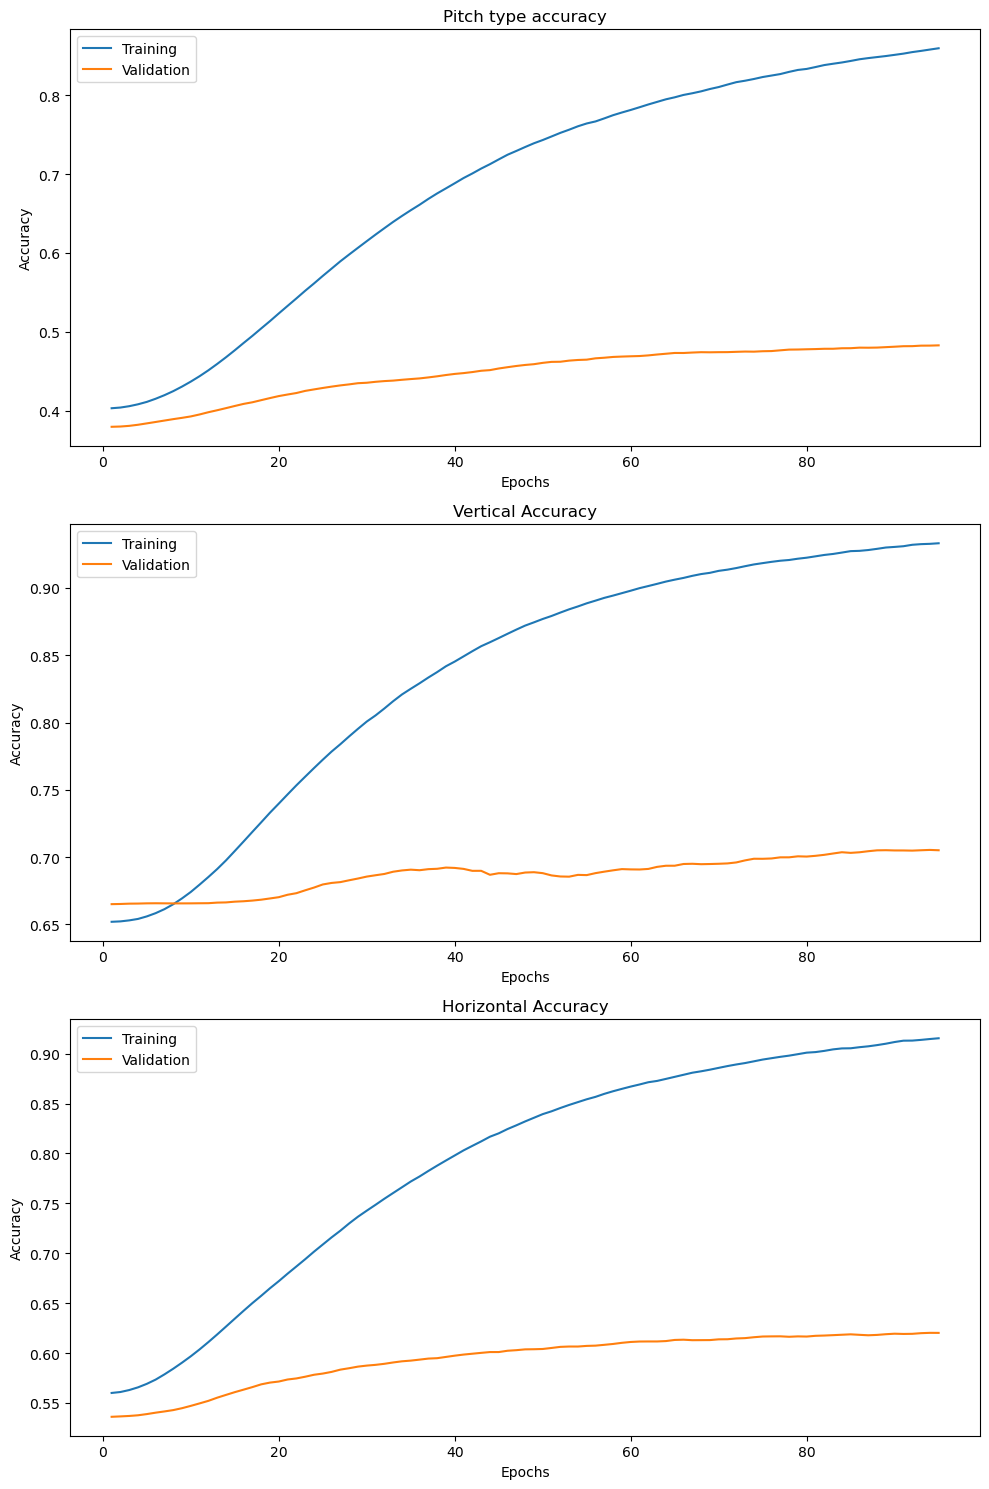

In [9]:
from utils.plot_utils import plot_ensemble_history

plot_ensemble_history(history)

## Scale up

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective=[keras_tuner.Objective('val_vertical_output_accuracy', direction='max'),
               keras_tuner.Objective('val_horizontal_output_accuracy', direction='max'),
               keras_tuner.Objective('val_pitch_output_accuracy', direction='max')],
    max_trials=5,
    project_name='self_learned_embeddings'
)

tuner.search(X_train, 
             {'pitch_output': y_pitch_train,
              'vertical_output': y_vertical_train,
              'horizontal_output': y_horizontal_train},
             epochs=200, batch_size=64, 
             validation_data=(X_val, 
                              {'pitch_output': y_pitch_val,
                               'vertical_output': y_vertical_val,
                               'horizontal_output': y_horizontal_val}),
             callbacks=[freeze_output_callback],
            )

best_model = tuner.get_best_models()[0]

best_model.summary()